# <div style="text-align: center"><font color='gray' textalign='center'>Lab 3: Classification</font></div>

In [1]:
import pandas as pd
import ds_functions as ds
import matplotlib.pyplot as plt

data = pd.read_csv('heart_failure_clinical_records_dataset.csv', sep = ',')
data = data.sample(frac=1) #to randomize the dataset order

data["sex"] = data["sex"].astype("bool")
data["anaemia"] = data["anaemia"].astype("bool")
data["diabetes"] = data["diabetes"].astype("bool")
data["high_blood_pressure"] = data["high_blood_pressure"].astype("bool")
data["smoking"] = data["smoking"].astype("bool")
data["DEATH_EVENT"] = data["DEATH_EVENT"].astype("bool")

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 3 * IQR)) |(data > (Q3 + 3 * IQR))).any(axis=1)]
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
173,50.0,True,115,False,20,False,189000.00,0.80,139,True,False,146,False
76,70.0,False,92,False,60,True,317000.00,0.80,140,False,True,74,False
128,61.0,False,248,False,30,True,267000.00,0.70,136,True,True,104,False
169,70.0,False,835,False,35,True,305000.00,0.80,133,False,False,145,False
101,75.0,False,582,False,45,True,263358.03,1.18,137,True,False,87,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,41.0,False,148,False,40,False,374000.00,0.80,140,True,True,68,False
127,58.0,True,200,True,60,False,300000.00,0.80,137,False,False,104,False
184,58.0,True,145,False,25,False,219000.00,1.20,137,True,True,170,True
186,50.0,False,582,False,50,False,153000.00,0.60,134,False,False,172,True


# <font color='gray'> Scaling </font>

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df_nr = data.select_dtypes(include='number')
df_sb = data.select_dtypes(include=['category', 'bool'])

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
df_nr = pd.DataFrame(transf.transform(df_nr), columns= df_nr.columns)
norm_data_zscore = df_nr.join(df_sb, how='right')
norm_data_zscore.describe(include='all')
#data = norm_data_zscore.dropna()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking,DEATH_EVENT
count,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,262,262,262,262,262,262
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145,151,167,167,179,184
mean,0.064749,-0.017687,-0.030513,-0.050129,0.025158,-0.018693,-0.000584,NaN,NaN,NaN,NaN,NaN,NaN
std,1.014181,0.979291,0.977325,0.984233,1.029944,1.001320,0.994190,NaN,NaN,NaN,NaN,NaN,NaN
min,-1.774766,-0.938924,-2.035074,-2.776781,-1.389472,-4.971738,-1.663728,NaN,NaN,NaN,NaN,NaN,NaN
25%,-0.754930,-0.717217,-0.693084,-0.649538,-0.689795,-0.648966,-0.753171,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.009947,-0.414653,-0.022089,-0.043114,-0.223344,0.071496,-0.154805,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.774824,0.500866,0.565032,0.408732,0.243106,0.551804,0.898840,NaN,NaN,NaN,NaN,NaN,NaN


# <font color='gray'> Training Models </font>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import train_test_split

target = 'DEATH_EVENT'
positive = True
negative = False
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop('DEATH_EVENT').values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)
labels.sort()

In [4]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=3) # 3 folds to keep the 70 / 30 ratio on train and test on each fold

# <font color='gray'> Naive Bayes - ZScore</font>

Average accuracy over the folds:  0.8358150470219435 std:  0.014950123267032357


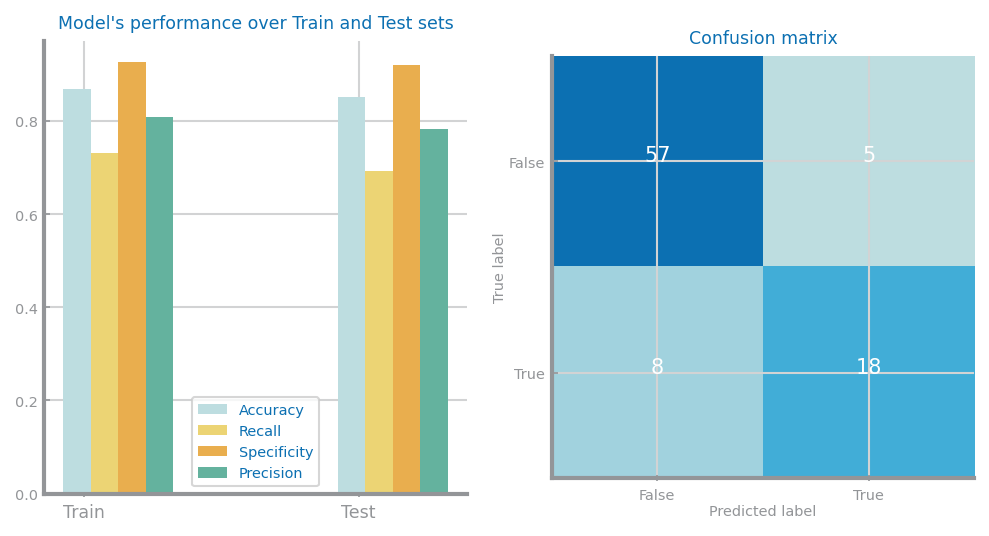

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import ds_functions as ds

y_hat_all = []
score_all = []
models = []
set_idxs = []
for train_index, test_index in kf.split(X, y):
    clf = GaussianNB()
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    set_idxs.append([trnX, tstX, trnY, tstY])
    clf = clf.fit(trnX, trnY)
    models.append(clf)
    y_hat = clf.predict(trnX)
    y_hat_all.append(y_hat)
    score_all.append(clf.score(tstX, tstY))

best_model_idx = score_all.index(max(score_all))
best_model = models[best_model_idx]
set_idxs = set_idxs[best_model_idx]
prd_trn = best_model.predict(set_idxs[0])
prd_tst = best_model.predict(set_idxs[1])

print("Average accuracy over the folds: ", sum(score_all)/len(score_all), "std: ", np.std(score_all))

ds.plot_evaluation_results(labels, set_idxs[2], prd_trn, set_idxs[3], prd_tst)

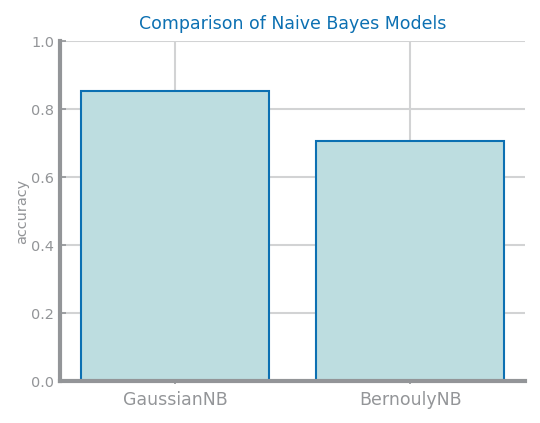

In [6]:
estimators = {'GaussianNB': GaussianNB(),
              'BernoulyNB': BernoulliNB()}

xvalues = []
yvalues = []
for clf in estimators:
    y_hat_all = []
    score_all = []
    models = []
    set_idxs = []
    for train_index, test_index in kf.split(X, y):
        model = estimators[clf]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        set_idxs.append([X_train, X_test, y_train, y_test])
        model = model.fit(X_train, y_train)
        models.append(model)
        y_hat = model.predict(X_test)
        y_hat_all.append(y_hat)
        score_all.append(model.score(X_test, y_test))
    
    best_model_idx = score_all.index(max(score_all))
    best_model = models[best_model_idx]
    set_idxs = set_idxs[best_model_idx]
    xvalues.append(clf)
    prdY = best_model.predict(set_idxs[1])
    yvalues.append(metrics.accuracy_score(set_idxs[3], prdY))

plt.figure()
ds.bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

# <font color='gray'> KNN - ZScore</font>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
import ds_functions as ds

score_all = []
set_idxs = []
for train_index, test_index in kf.split(X, y):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    set_idxs.append([trnX, tstX, trnY, tstY])
    nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
    dist = ['manhattan', 'euclidean', 'chebyshev']
    values = {}
    train_values = {}
    best = (0, '')
    last_best = 0
    for d in dist:
        yvalues = []
        y_trn_values = []
        for n in nvalues:
            knn = KNeighborsClassifier(n_neighbors=n, metric=d)
            knn.fit(trnX, trnY)
            prdY = knn.predict(tstX)
            prd_trn_Y = knn.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
            if yvalues[-1] > last_best:
                best = (n, d)
                last_best = yvalues[-1]
        values[d] = yvalues
        train_values[d] = y_trn_values
    score_all.append(last_best)

print("Average accuracy over the folds: ", sum(score_all)/len(score_all), "std: ", np.std(score_all))
best_model_idx = score_all.index(max(score_all))
set_idxs = set_idxs[best_model_idx]

Average accuracy over the folds:  0.7213079066527343 std:  0.01225306944062373


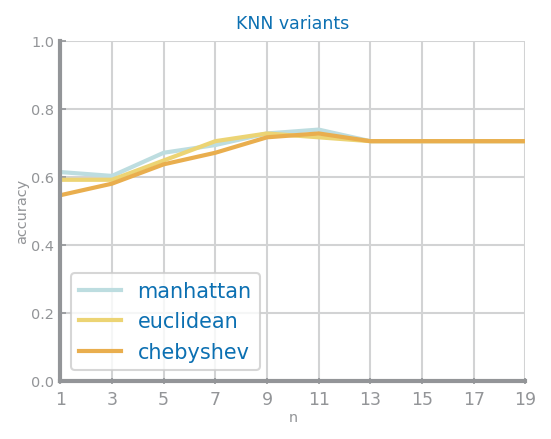

Best results with 11 neighbors and manhattan


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
import ds_functions as ds

trnX, tstX, trnY, tstY = set_idxs
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
train_values = {}
best = (0, '')
last_best = 0
for d in dist:
    yvalues = []
    y_trn_values = []
    for n in nvalues:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(trnX, trnY)
        prdY = knn.predict(tstX)
        prd_trn_Y = knn.predict(trnX)
        yvalues.append(metrics.accuracy_score(tstY, prdY))
        y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
        if yvalues[-1] > last_best:
            best = (n, d)
            last_best = yvalues[-1]
    values[d] = yvalues
    train_values[d] = y_trn_values

plt.figure()
ds.multiple_line_chart(nvalues, values, title='KNN variants', xlabel='n', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with %d neighbors and %s'%(best[0], best[1]))

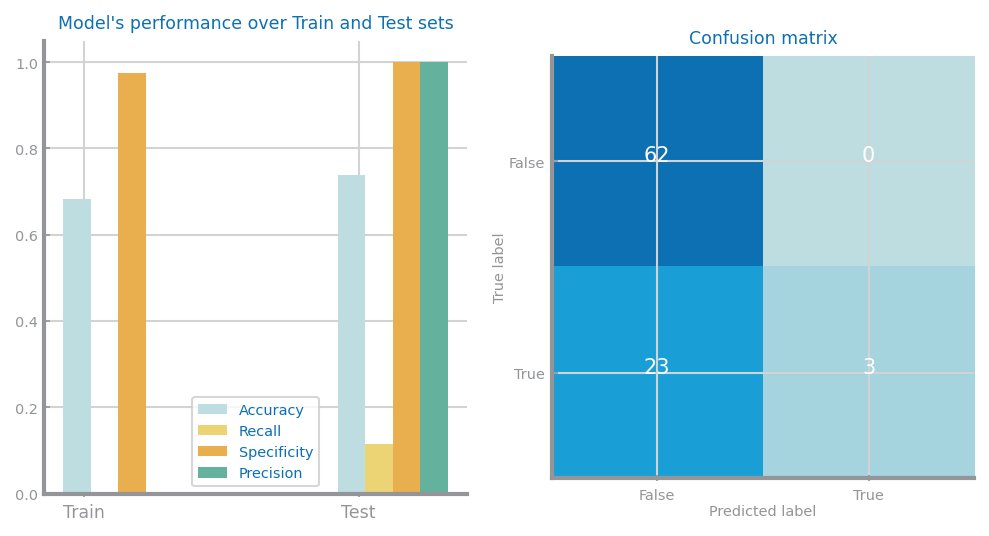

In [9]:
clf = knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1])
clf.fit(trnX, trnY)
prd_trn = clf.predict(trnX)
prd_tst = clf.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

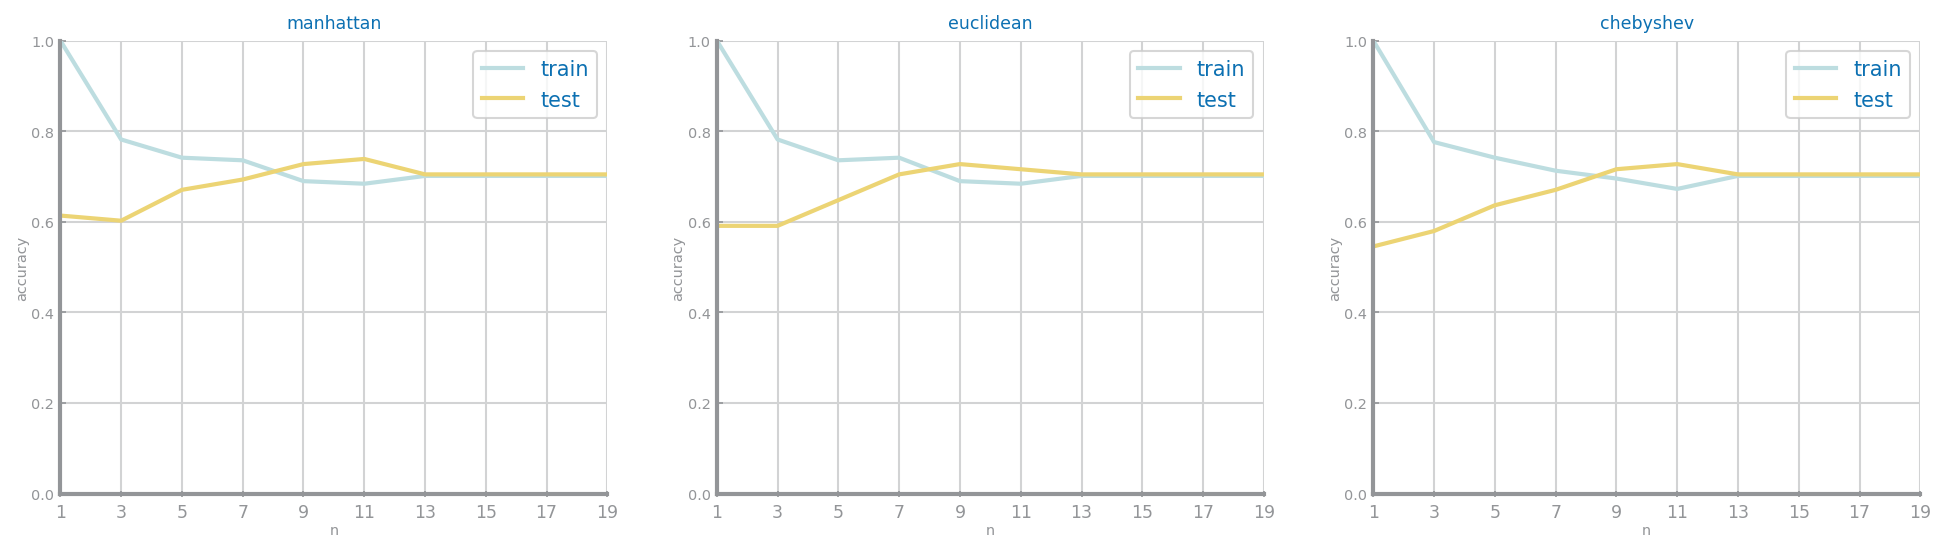

In [10]:
plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(16, 4), squeeze=False)
for i in range(len(dist)):
    ds.multiple_line_chart(nvalues, {'train': train_values[dist[i]], 'test': values[dist[i]]}, ax=axs[0, i], title=dist[i], xlabel='n', ylabel='accuracy', percentage=True)
plt.show()

# <font color='gray'>Decision Trees - ZScore</font>


In [11]:
from sklearn.tree import DecisionTreeClassifier

score_all = []
set_idxs = []

for train_index, test_index in kf.split(X,y):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    set_idxs.append([trnX, tstX, trnY, tstY])
    min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
    max_depths = [2, 5, 10, 15, 20, 25]
    criteria = ['entropy', 'gini']
    best = ('',  0, 0.0)
    last_best = 0
    best_tree = None

    criteria_test_values = {}
    criteria_train_values = {}

    for k in range(len(criteria)):
        f = criteria[k]
        values = {}
        train_values = {}
        for d in max_depths:
            yvalues = []
            y_trn_values = []
            for imp in min_impurity_decrease:
                tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=d, criterion=f, min_impurity_decrease=imp)
                tree.fit(trnX, trnY)
                prdY = tree.predict(tstX)
                prd_trn_Y = tree.predict(trnX)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
                if yvalues[-1] > last_best:
                    best = (f, d, imp)
                    last_best = yvalues[-1]
                    best_tree = tree

            values[d] = yvalues
            train_values[d] = y_trn_values
        
        criteria_test_values[f] = values
        criteria_train_values[f] = train_values
    score_all.append(last_best)

print("Average accuracy over the folds: ", sum(score_all)/len(score_all), "std: ", np.std(score_all))
best_model_idx = score_all.index(max(score_all))
set_idxs = set_idxs[best_model_idx]

Average accuracy over the folds:  0.8319836293974227 std:  0.015094482032089894


<Figure size 600x450 with 0 Axes>

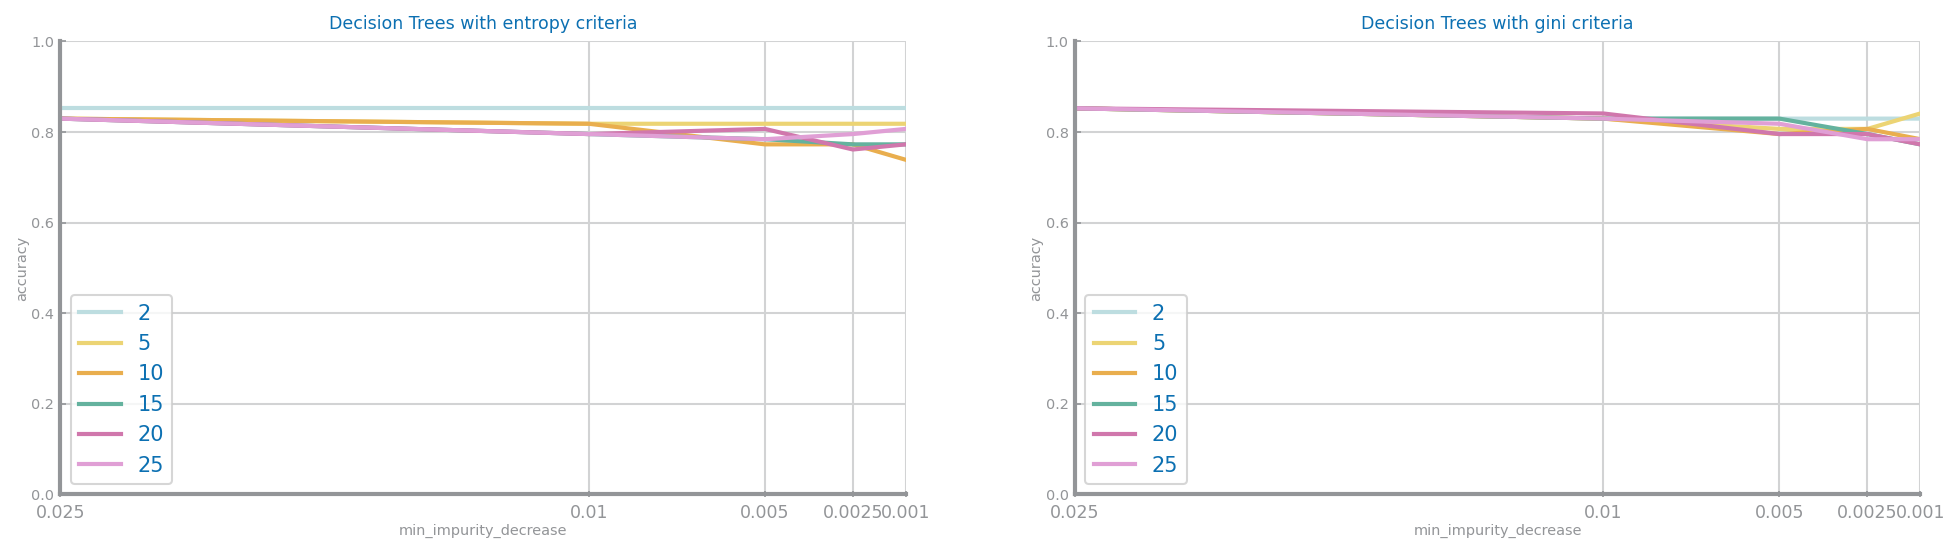

Best results achieved with entropy criteria, depth=2 and min_impurity_decrease=0.03 ==> accuracy=0.85


In [12]:
from sklearn.tree import DecisionTreeClassifier

trnX, tstX, trnY, tstY = set_idxs
min_impurity_decrease = [0.025, 0.01, 0.005, 0.0025, 0.001]
max_depths = [2, 5, 10, 15, 20, 25]
criteria = ['entropy', 'gini']
best = ('',  0, 0.0)
last_best = 0
best_tree = None

criteria_test_values = {}
criteria_train_values = {}

plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(16, 4), squeeze=False)
for k in range(len(criteria)):
    f = criteria[k]
    values = {}
    train_values = {}
    for d in max_depths:
        yvalues = []
        y_trn_values = []
        for imp in min_impurity_decrease:
            tree = DecisionTreeClassifier(min_samples_leaf=1, max_depth=d, criterion=f, min_impurity_decrease=imp)
            tree.fit(trnX, trnY)
            prdY = tree.predict(tstX)
            prd_trn_Y = tree.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_Y))
            if yvalues[-1] > last_best:
                best = (f, d, imp)
                last_best = yvalues[-1]
                best_tree = tree

        values[d] = yvalues
        train_values[d] = y_trn_values
    ds.multiple_line_chart(min_impurity_decrease, values, ax=axs[0, k], title='Decision Trees with %s criteria'%f,
                           xlabel='min_impurity_decrease', ylabel='accuracy', percentage=True)
    
    criteria_test_values[f] = values
    criteria_train_values[f] = train_values
    

plt.show()
print('Best results achieved with %s criteria, depth=%d and min_impurity_decrease=%1.2f ==> accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

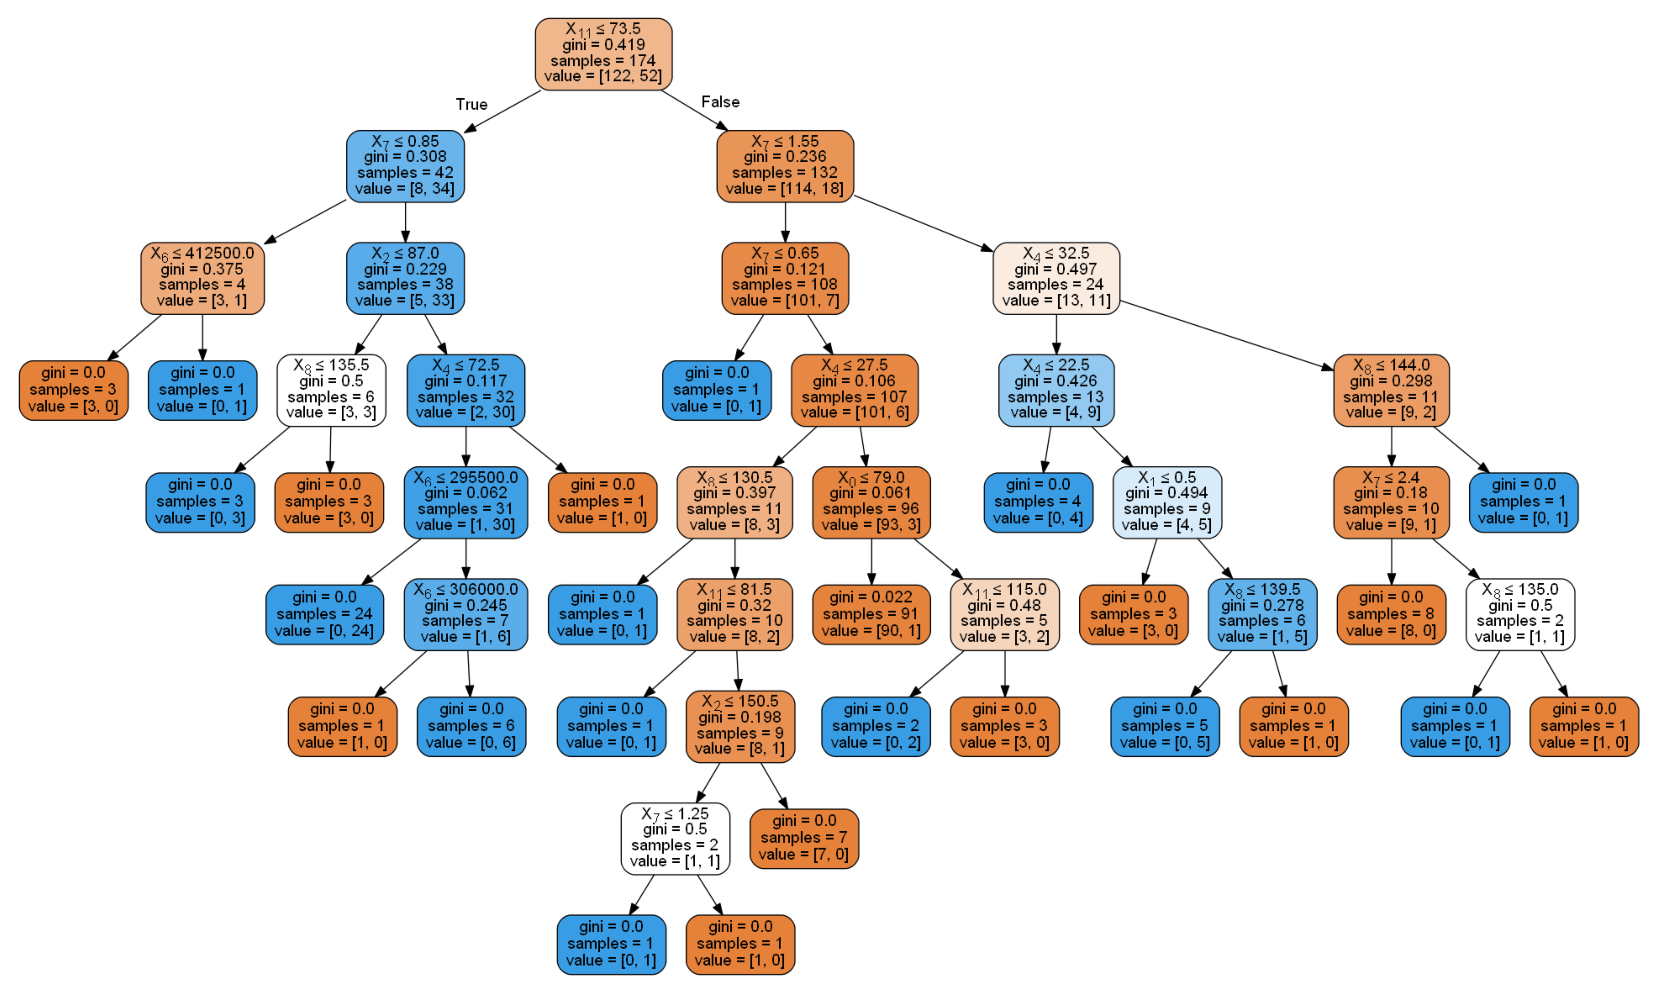

In [13]:
from sklearn.tree import export_graphviz
import pydot

dot_data = export_graphviz(tree, out_file='dtree.dot', filled=True, rounded=True, special_characters=True)
# Convert to png
(graph,) = pydot.graph_from_dot_file('dtree.dot')
graph.write_png('dtree.png')

plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('dtree.png'))
plt.axis('off')
plt.show()

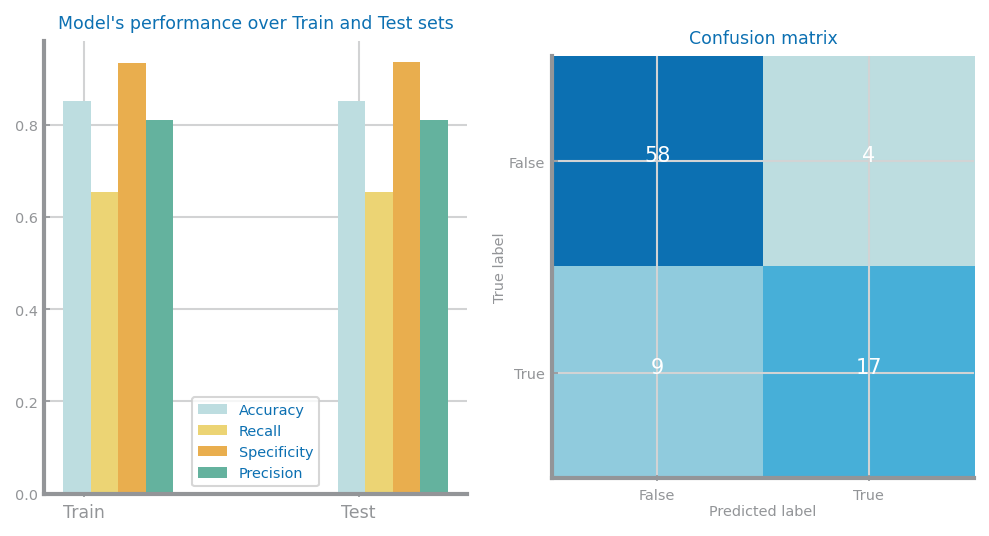

In [14]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

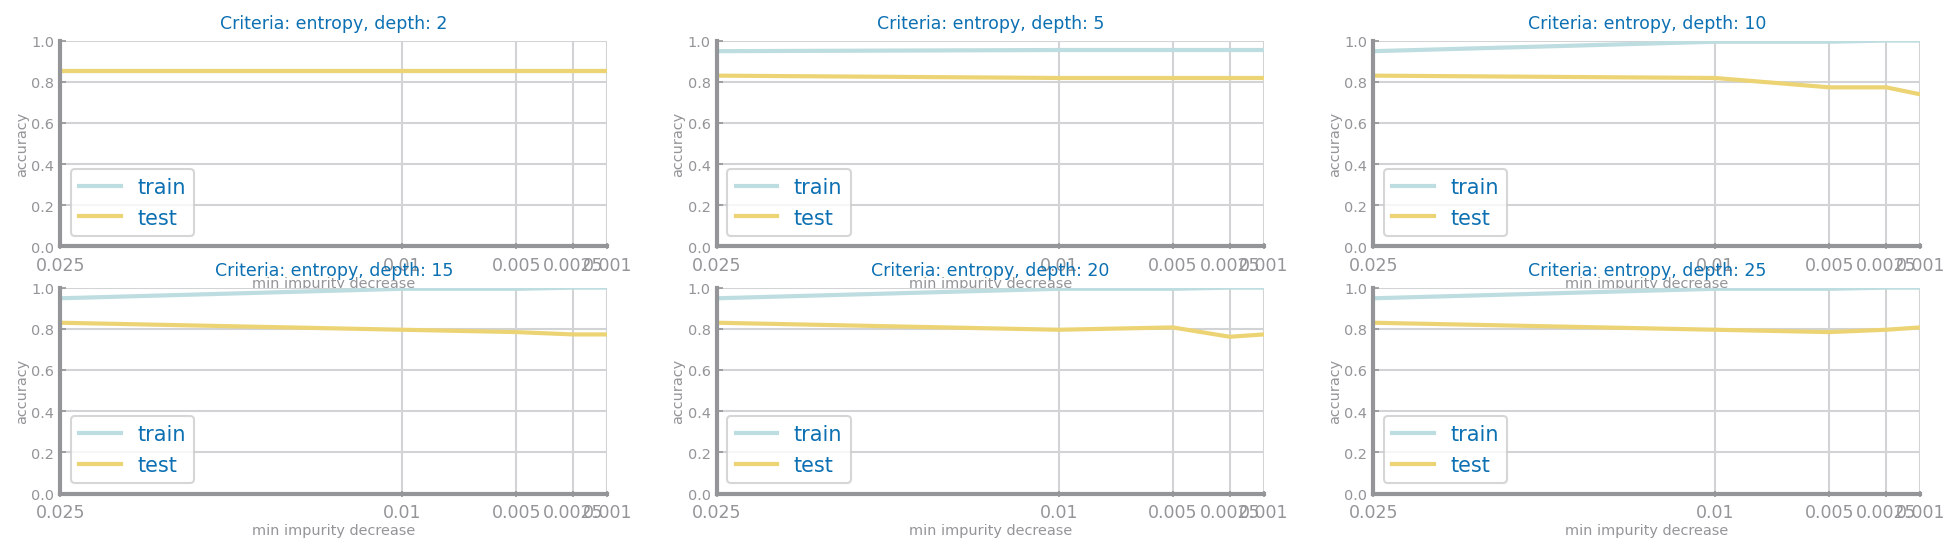

<Figure size 600x450 with 0 Axes>

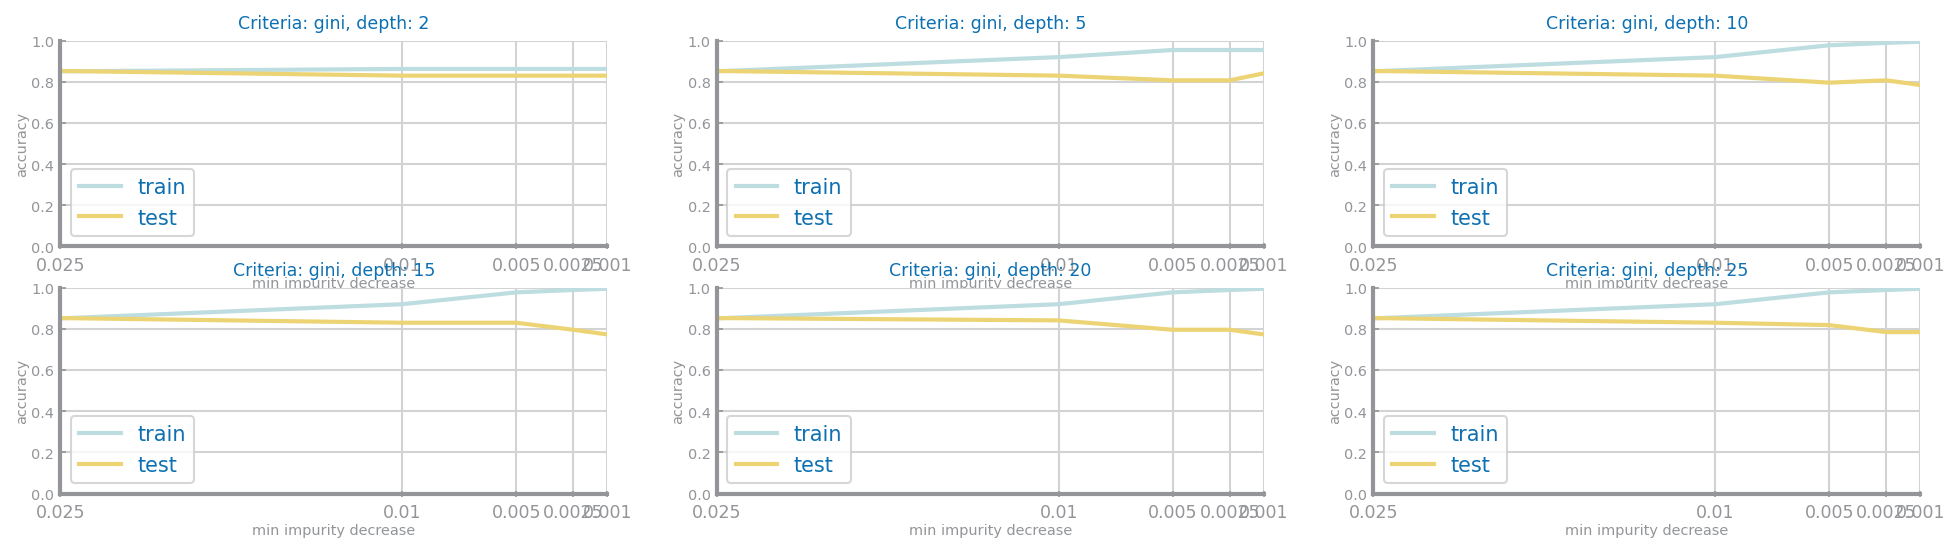

In [15]:
for j in range(len(criteria)):
    train_values = criteria_train_values[criteria[j]]
    test_values = criteria_test_values[criteria[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(max_depths)):
        ds.multiple_line_chart(min_impurity_decrease, {'train': train_values[max_depths[i]], 'test': test_values[max_depths[i]]}, ax=axs[int(i/3), i%3], title='Criteria: ' + criteria[j]+ ', depth: ' + str(max_depths[i]), xlabel='min impurity decrease', ylabel='accuracy', percentage=True)
    plt.show()

# <font color='gray'>Random Forests - ZScore Data</font>

In [16]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier

score_all = []
set_idxs = []
for train_index, test_index in kf.split(X,y):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    set_idxs.append([trnX, tstX, trnY, tstY])

    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    max_features = [.1, .3, .5, .7, .9, 1]
    best = ('', 0, 0)
    last_best = 0
    best_tree = None

    max_depth_test_values = {}
    max_depth_train_values = {}

    cols = len(max_depths)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        train_values = {}
        for f in max_features:
            yvalues = []
            y_trn_values = []
            for n in n_estimators:
                rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(trnX, trnY)
                prdY = rf.predict(tstX)
                prd_trn_y = rf.predict(trnX)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_y))
                if yvalues[-1] > last_best:
                    best = (d, f, n)
                    last_best = yvalues[-1]
                    best_tree = rf

            values[f] = yvalues
            train_values[f] = y_trn_values

        max_depth_test_values[max_depths[k]] = values
        max_depth_train_values[max_depths[k]] = train_values

    score_all.append(last_best)

print("Average accuracy over the folds: ", sum(score_all)/len(score_all), "std: ", np.std(score_all))
best_model_idx = score_all.index(max(score_all))
set_idxs = set_idxs[best_model_idx]
    

Average accuracy over the folds:  0.8739115290839429 std:  0.02531430485629624


<Figure size 600x450 with 0 Axes>

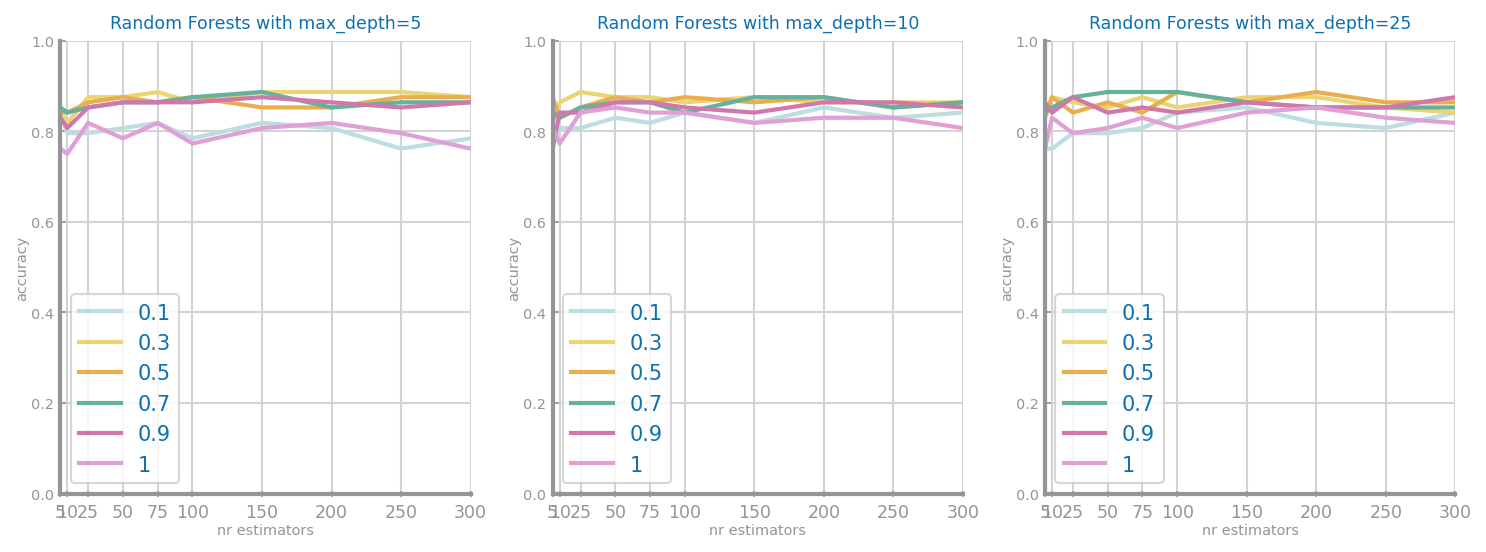

Best results with depth=5, 0.30 features and 75 estimators, with accuracy=0.89


In [17]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier

trnX, tstX, trnY, tstY = set_idxs
n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = ('', 0, 0)
last_best = 0
best_tree = None


max_depth_test_values = {}
max_depth_train_values = {}

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    train_values = {}
    for f in max_features:
        yvalues = []
        y_trn_values = []
        for n in n_estimators:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            rf.fit(trnX, trnY)
            prdY = rf.predict(tstX)
            prd_trn_y = rf.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_y))
            if yvalues[-1] > last_best:
                best = (d, f, n)
                last_best = yvalues[-1]
                best_tree = rf

        values[f] = yvalues
        train_values[f] = y_trn_values
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    
    max_depth_test_values[max_depths[k]] = values
    max_depth_train_values[max_depths[k]] = train_values
    
    
plt.show()
print('Best results with depth=%d, %1.2f features and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

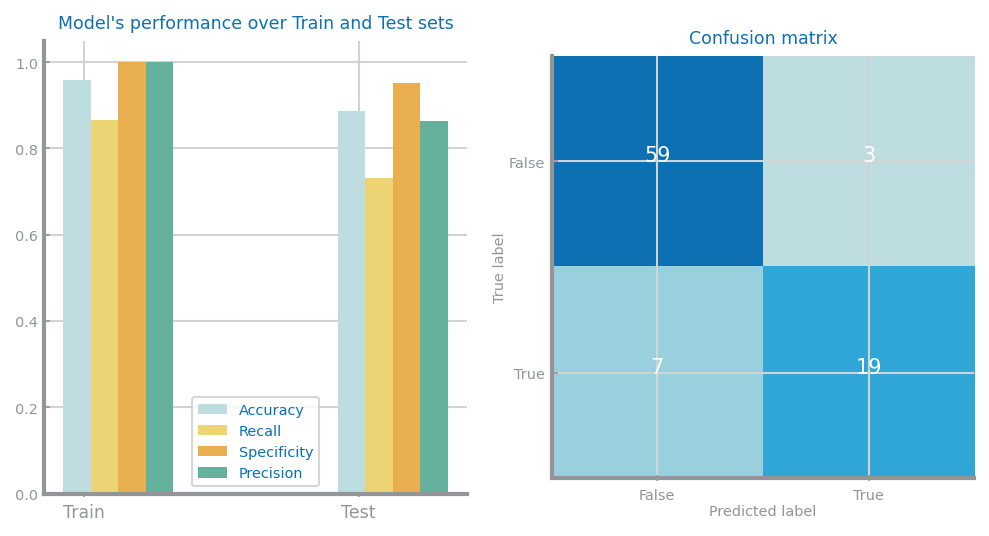

In [18]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

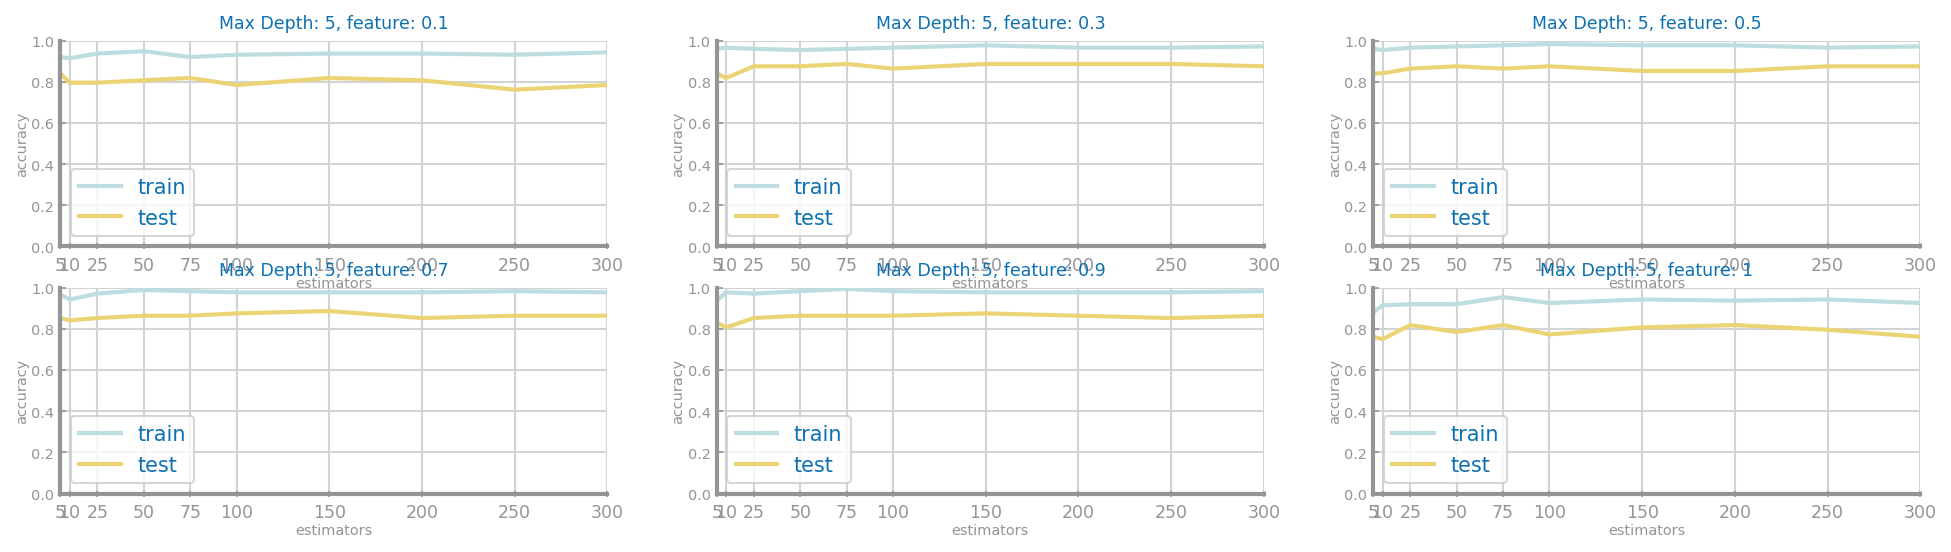

<Figure size 600x450 with 0 Axes>

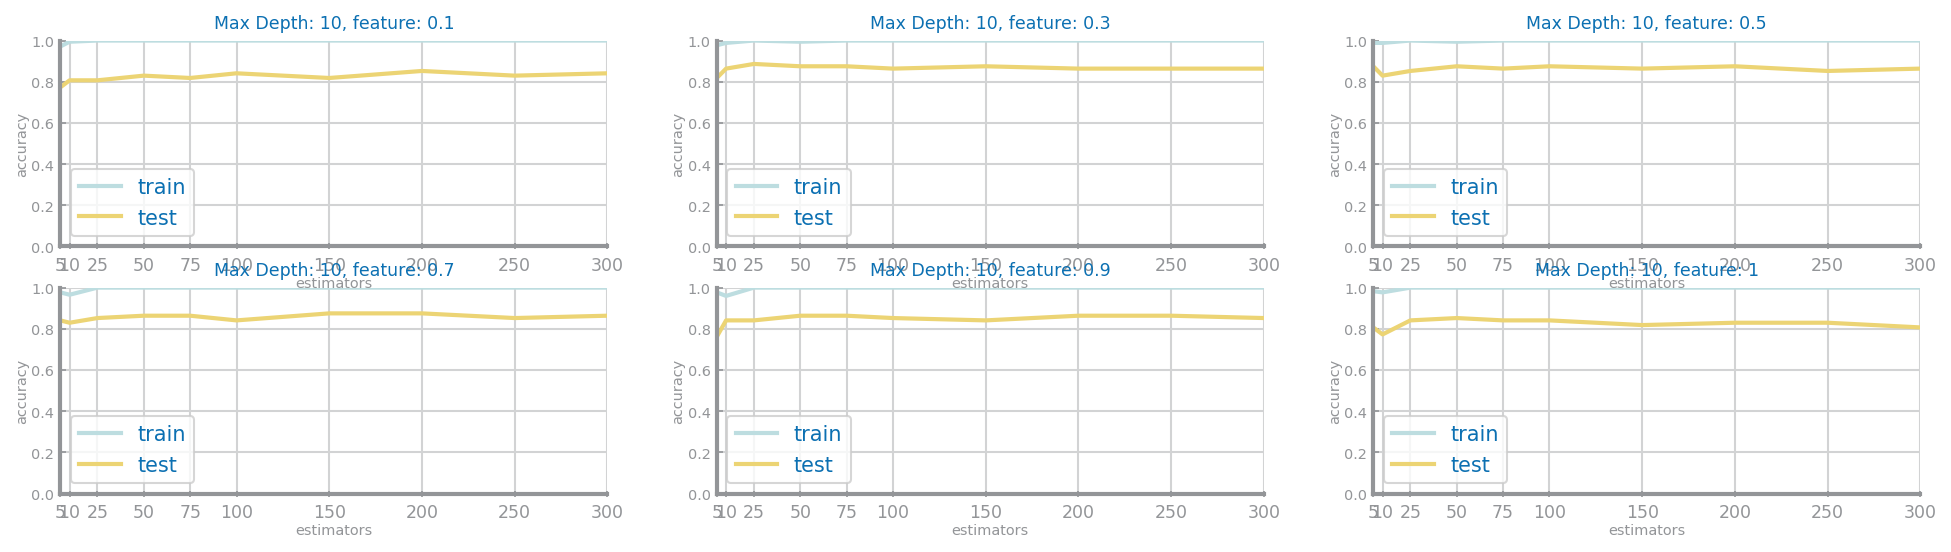

<Figure size 600x450 with 0 Axes>

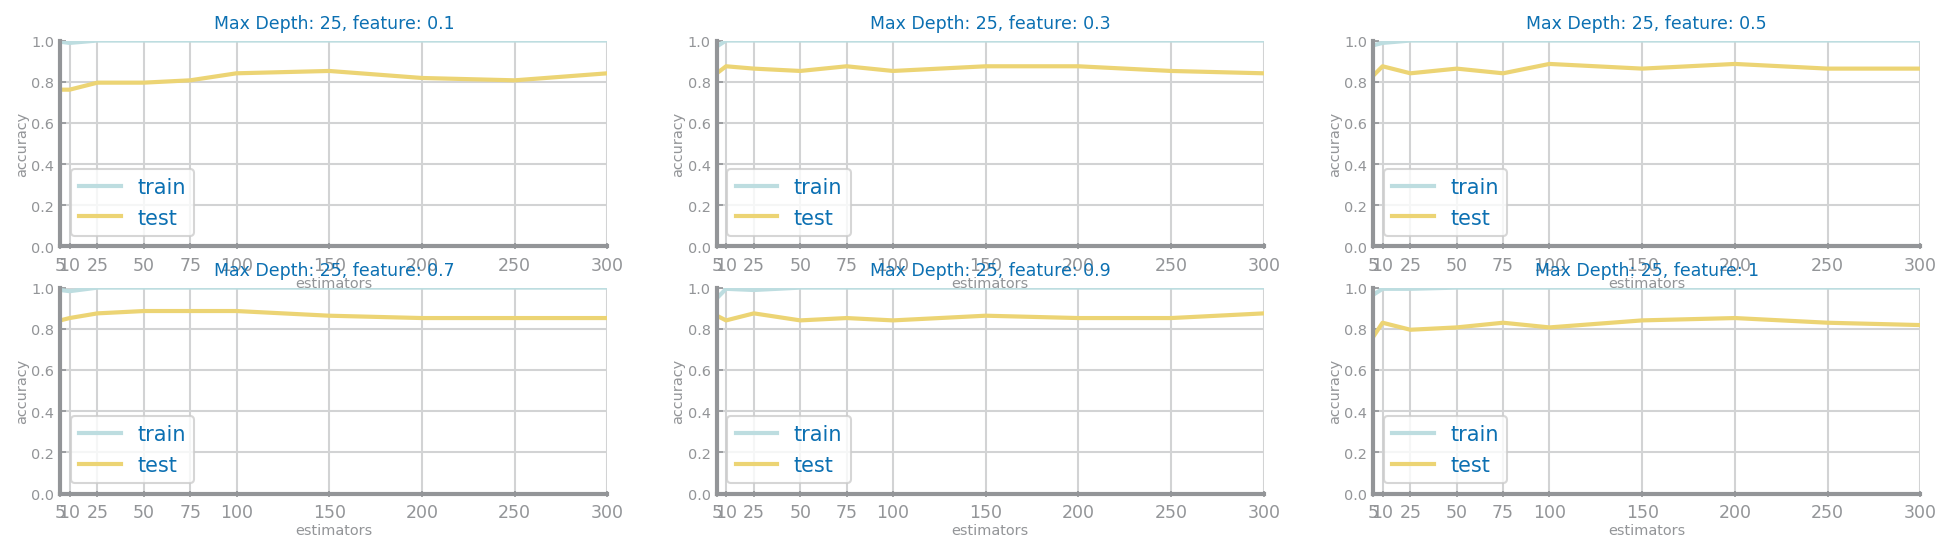

In [19]:
for j in range(len(max_depths)):
    train_values = max_depth_train_values[max_depths[j]]
    test_values = max_depth_test_values[max_depths[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(max_features)):
        ds.multiple_line_chart(n_estimators, {'train': train_values[max_features[i]], 'test': test_values[max_features[i]]}, ax=axs[int(i/3), i%3], title='Max Depth: ' + str(max_depths[j]) + ', feature: ' + str(max_features[i]), xlabel='estimators', ylabel='accuracy', percentage=True)
    plt.show()

# <font color='gray'>Logistic Regression - ZScore</font>

Average accuracy over the folds:  0.8359021246952282 std:  0.01930072257767276


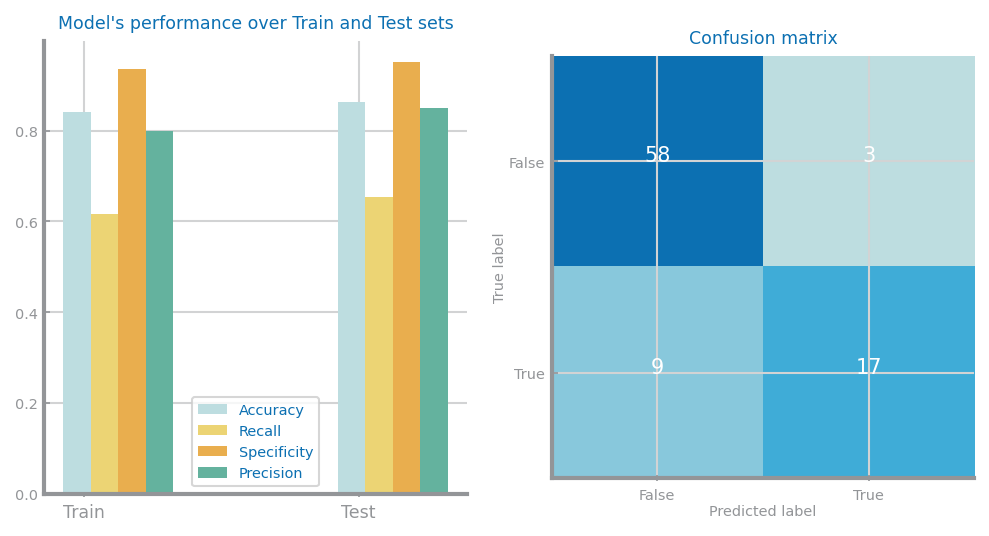

In [20]:
from sklearn.linear_model import LogisticRegression

y_hat_all = []
score_all = []
models = []
set_idxs = []
for train_index, test_index in kf.split(X, y):
    clf = LogisticRegression(random_state = 0)
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    set_idxs.append([trnX, tstX, trnY, tstY])
    clf = clf.fit(trnX, trnY)
    models.append(clf)
    y_hat = clf.predict(trnX)
    y_hat_all.append(y_hat)
    score_all.append(clf.score(tstX, tstY))

best_model_idx = score_all.index(max(score_all))
best_model = models[best_model_idx]
set_idxs = set_idxs[best_model_idx]
prd_trn = best_model.predict(set_idxs[0])
prd_tst = best_model.predict(set_idxs[1])

print("Average accuracy over the folds: ", sum(score_all)/len(score_all), "std: ", np.std(score_all))

ds.plot_evaluation_results(labels, set_idxs[2], prd_trn, set_idxs[3], prd_tst)

# <font color='gray'>Gradient Boosting - Zscore</font>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.ensemble import GradientBoostingClassifier
import ds_functions as ds

score_all = []
set_idxs = []
for train_index, test_index in kf.split(X,y):
    trnX, tstX = X[train_index], X[test_index]
    trnY, tstY = y[train_index], y[test_index]
    set_idxs.append([trnX, tstX, trnY, tstY])
    
    n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
    max_depths = [5, 10, 25]
    learning_rate = [.1, .3, .5, .7, .9]
    best = ('', 0, 0)
    last_best = 0
    best_tree = None

    cols = len(max_depths)
    for k in range(len(max_depths)):
        d = max_depths[k]
        values = {}
        for lr in learning_rate:
            yvalues = []
            for n in n_estimators:
                gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
                gb.fit(trnX, trnY)
                prdY = gb.predict(tstX)
                yvalues.append(metrics.accuracy_score(tstY, prdY))
                if yvalues[-1] > last_best:
                    best = (d, lr, n)
                    last_best = yvalues[-1]
                    best_tree = gb
            values[lr] = yvalues
            
    score_all.append(last_best)

print("Average accuracy over the folds: ", sum(score_all)/len(score_all), "std: ", np.std(score_all))
best_model_idx = score_all.index(max(score_all))
set_idxs = set_idxs[best_model_idx]

Average accuracy over the folds:  0.8510536398467433 std:  0.019359562194835003


<Figure size 600x450 with 0 Axes>

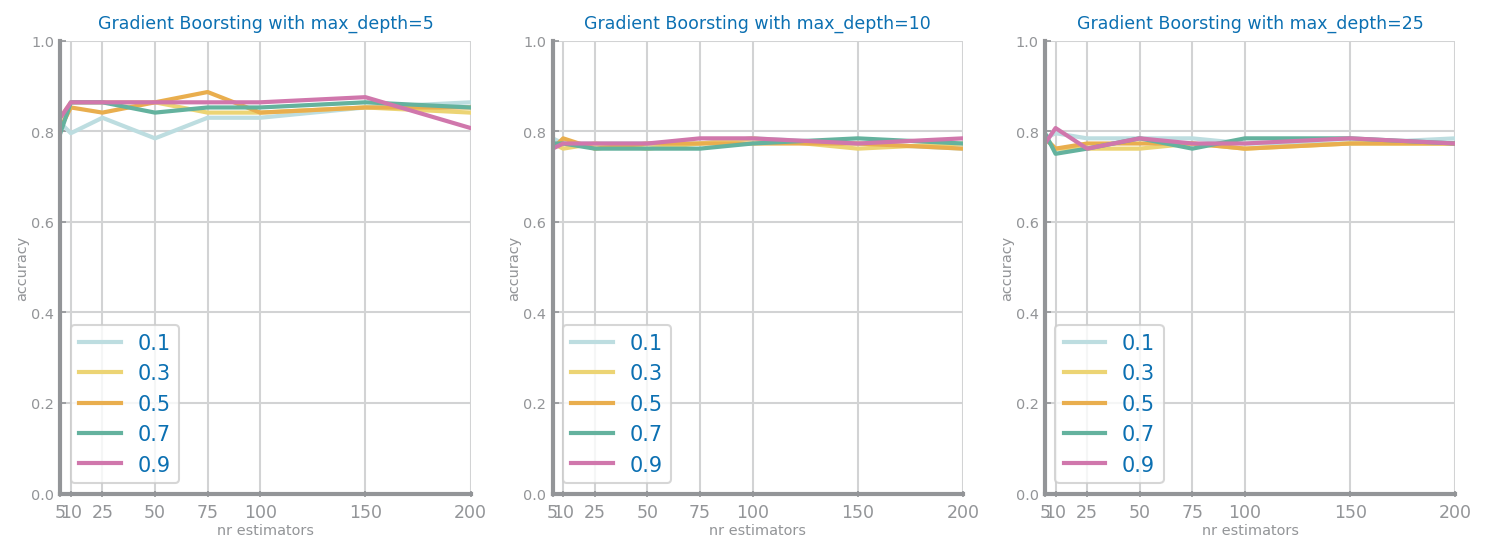

Best results with depth=5, learning rate=0.50 and 75 estimators, with accuracy=0.89


In [22]:
trnX, tstX, trnY, tstY = set_idxs

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200]
max_depths = [5, 10, 25]
learning_rate = [.1, .3, .5, .7, .9]
best = ('', 0, 0)
last_best = 0
best_tree = None

max_depth_test_values = {}
max_depth_train_values = {}

cols = len(max_depths)
plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    train_values = {}
    for lr in learning_rate:
        yvalues = []
        y_trn_values = []
        for n in n_estimators:
            gb = GradientBoostingClassifier(n_estimators=n, max_depth=d, learning_rate=lr)
            gb.fit(trnX, trnY)
            prdY = gb.predict(tstX)
            prd_trn_y = gb.predict(trnX)
            yvalues.append(metrics.accuracy_score(tstY, prdY))
            y_trn_values.append(metrics.accuracy_score(trnY, prd_trn_y))
            if yvalues[-1] > last_best:
                best = (d, lr, n)
                last_best = yvalues[-1]
                best_tree = gb
        values[lr] = yvalues
        train_values[lr] = y_trn_values
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Gradient Boorsting with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
    max_depth_test_values[max_depths[k]] = values
    max_depth_train_values[max_depths[k]] = train_values

plt.show()
print('Best results with depth=%d, learning rate=%1.2f and %d estimators, with accuracy=%1.2f'%(best[0], best[1], best[2], last_best))

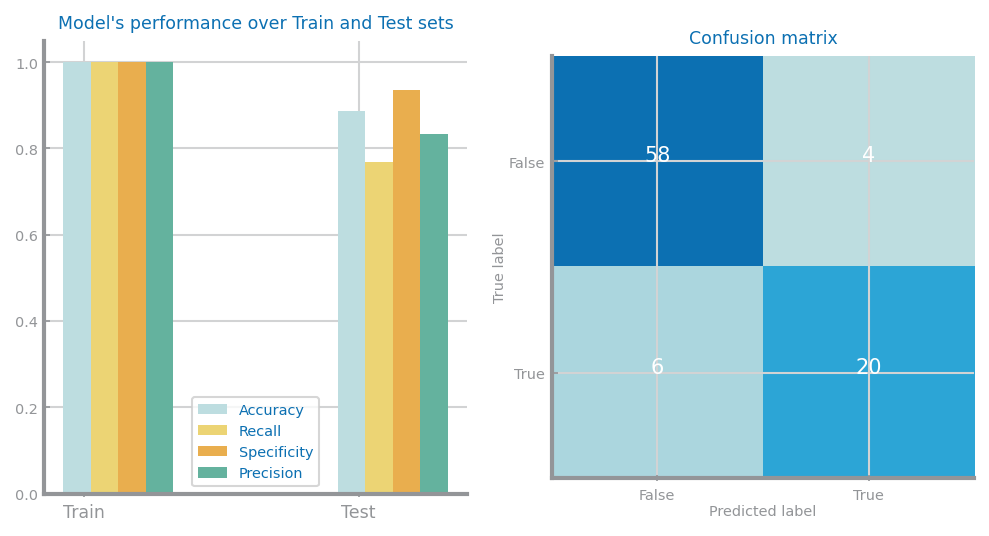

In [23]:
prd_trn = best_tree.predict(trnX)
prd_tst = best_tree.predict(tstX)
ds.plot_evaluation_results(labels, trnY, prd_trn, tstY, prd_tst)

<Figure size 600x450 with 0 Axes>

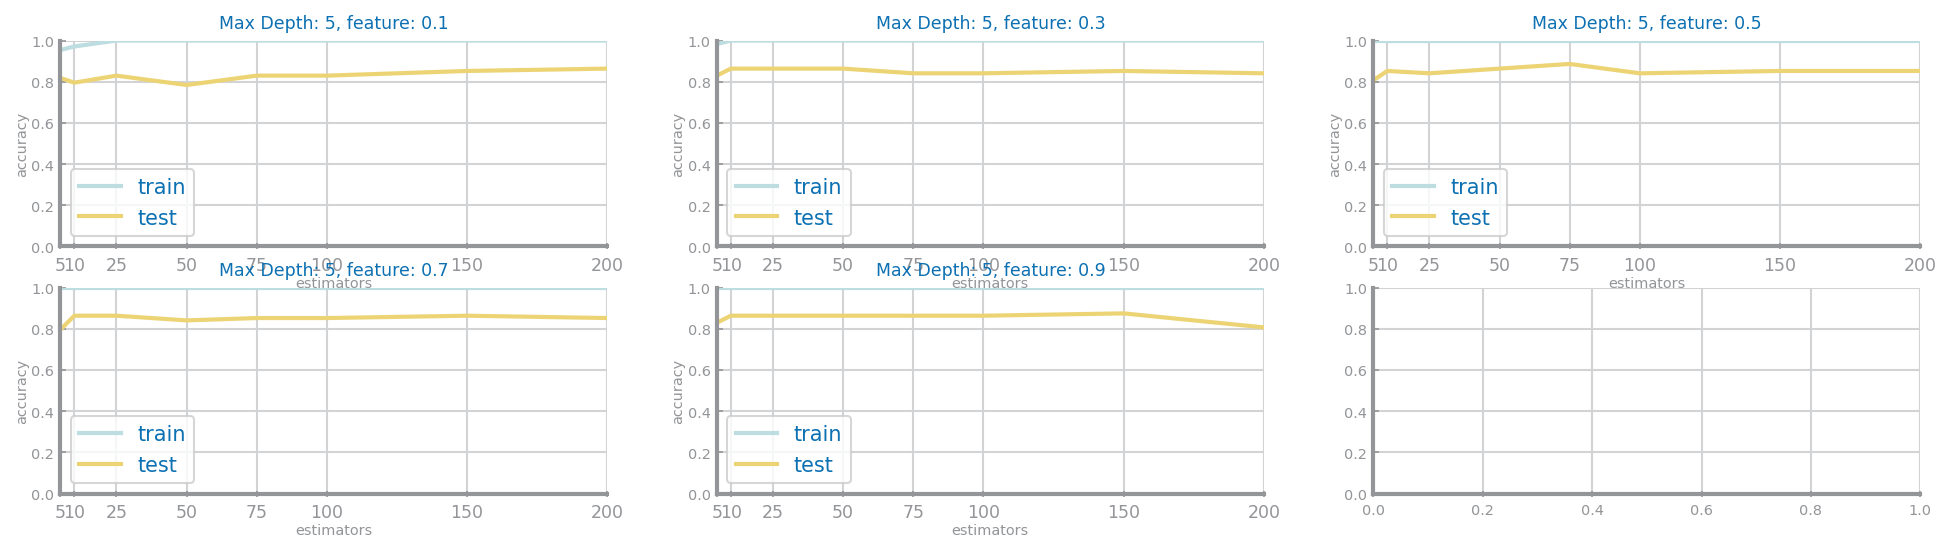

<Figure size 600x450 with 0 Axes>

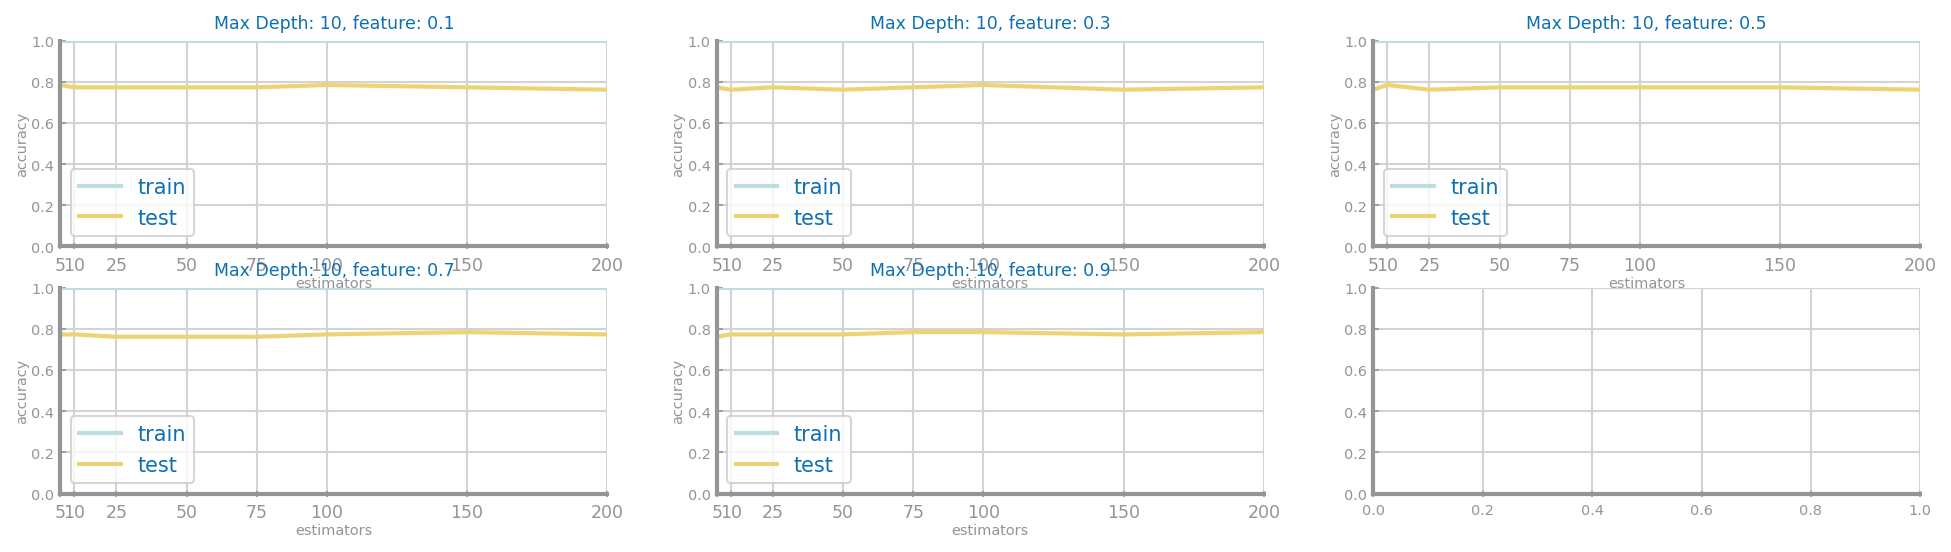

<Figure size 600x450 with 0 Axes>

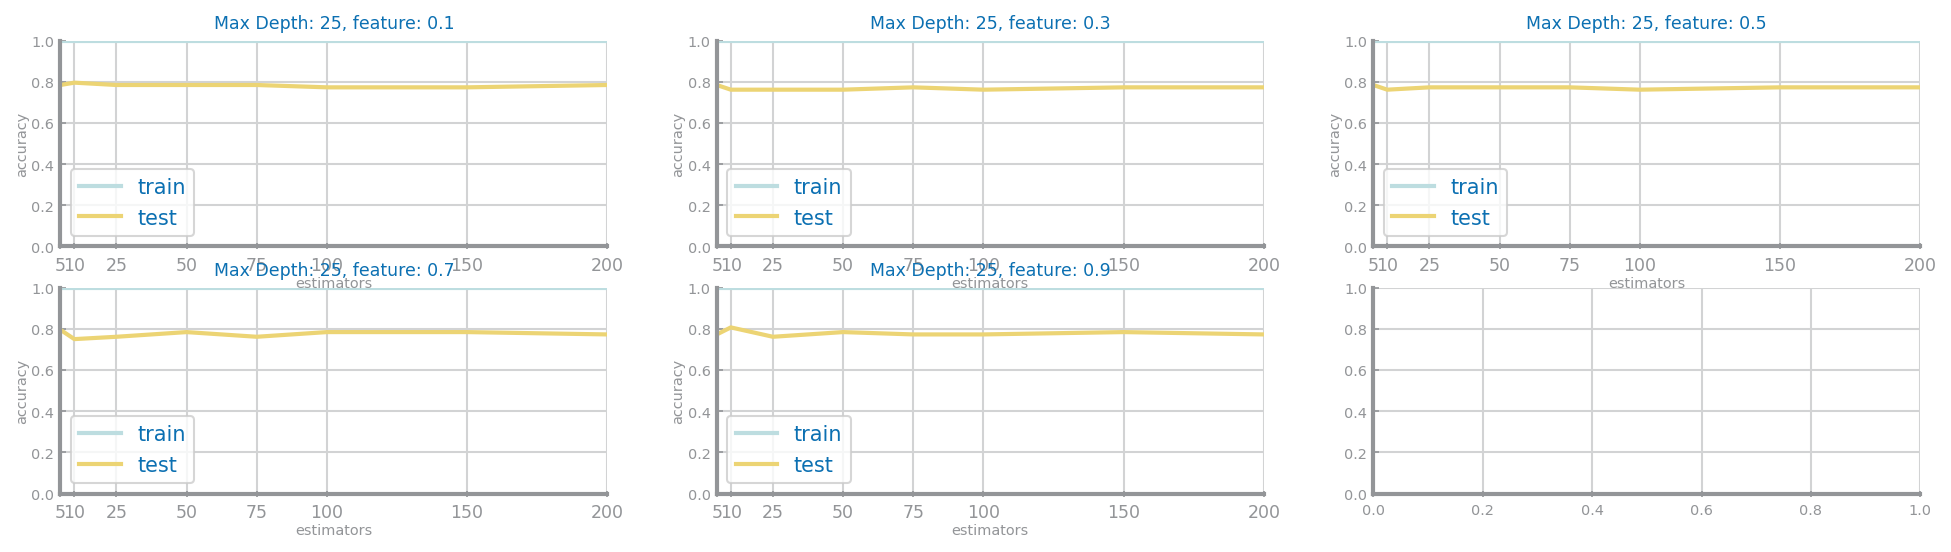

In [24]:
for j in range(len(max_depths)):
    train_values = max_depth_train_values[max_depths[j]]
    test_values = max_depth_test_values[max_depths[j]]
    plt.figure()
    fig, axs = plt.subplots(2, 3, figsize=(16, 4), squeeze=False)
    for i in range(len(learning_rate)):
        ds.multiple_line_chart(n_estimators, {'train': train_values[learning_rate[i]], 'test': test_values[learning_rate[i]]}, ax=axs[int(i/3), i%3], title='Max Depth: ' + str(max_depths[j]) + ', feature: ' + str(learning_rate[i]), xlabel='estimators', ylabel='accuracy', percentage=True)
    plt.show()